# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [77]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

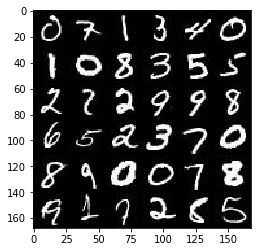

In [78]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

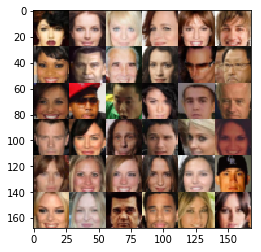

In [79]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the tuple (tensor of real input images, tensor of z data)

In [81]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [82]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    def leaky_ReLU(x):
        ALPHA = 0.2
        return tf.maximum(ALPHA * x, x)
    
    def convolution(x, filters, strides=2):
        return tf.layers.conv2d(x,
                                filters,
                                5,
                                strides=strides,
                                padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                bias_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    def dropout(x):
        KEEP_PROB = 0.8
        return tf.nn.dropout(x, KEEP_PROB)
    
    def batch_normalization(x):
        return tf.layers.batch_normalization(x, training=True)
    
    def dense(x):
        return tf.layers.dense(x,
                               1,
                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                               bias_initializer=tf.contrib.layers.xavier_initializer())
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Dimensions: -1*28*28*Depth, where Depth is either 1 or 3

        # Convolution layer 1
        layer1 = convolution(images, filters=64)
        layer1 = leaky_ReLU(layer1)
        layer1 = dropout(layer1)
        # Dimensions: 14x14x64

        # Convolution layer 2
        layer2 = convolution(layer1, filters=128)
        layer2 = batch_normalization(layer2)
        layer2 = leaky_ReLU(layer2)
        layer2 = dropout(layer2)
        # Dimensions: 7x7x128

        # Convolution layer 3
        layer3 = convolution(layer2, filters=256, strides=1)
        layer3 = batch_normalization(layer3)
        layer3 = leaky_ReLU(layer3)
        layer3 = dropout(layer3)
        # Dimensions: 7x7x256

        # Output layer
        flattened_layer3 = tf.contrib.layers.flatten(layer3)
        single_logit = dense(flattened_layer3)
        output = tf.sigmoid(single_logit)

        return output, single_logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [83]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    def leaky_ReLU(x):
        ALPHA = 0.2
        return tf.maximum(ALPHA * x, x)
    
    def transposed_convolution(x, filters, strides=2):
        return tf.layers.conv2d_transpose(x,
                                          filters,
                                          5,
                                          strides=strides,
                                          padding='same',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          bias_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    

    def dropout(x, is_training):
        if is_train:
            DROPOUT_RATE = 0.5
            return tf.layers.dropout(x, rate=DROPOUT_RATE)
        else:
            return x

    def batch_normalization(x):
        return tf.layers.batch_normalization(x, training=is_train)

    def dense(x, units):
        return tf.layers.dense(x,
                               units,
                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                               bias_initializer=tf.contrib.layers.xavier_initializer())

    with tf.variable_scope('generator', reuse=(not is_train)):
        # Fully connected layer
        layer1 = dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = batch_normalization(layer1)
        layer1 = leaky_ReLU(layer1)
        layer1 = dropout(layer1, is_train)
        # Dimensions: -1x7x7x512

        # Transposed convolution layer 1
        layer2 = transposed_convolution(layer1, filters=256, strides=1)
        layer2 = batch_normalization(layer2)
        layer2 = leaky_ReLU(layer2)
        layer2 = dropout(layer2, is_train)
        # Dimensions: -1x7x7x256

        # Transposed convolution layer 2
        layer3 = transposed_convolution(layer2, filters=128)
        layer3 = batch_normalization(layer3)
        layer3 = leaky_ReLU(layer3)
        layer3 = dropout(layer3, is_train)
        # Dimensions: -1x14x14x128

        # Transposed convolution layer 3
        layer4 = transposed_convolution(layer3, filters=64, strides=1)
        layer4 = batch_normalization(layer4)
        layer4 = leaky_ReLU(layer4)
        layer4 = dropout(layer4, is_train)
        # Dimensions: -1x14x14x64
        
        # Output layer
        logits = transposed_convolution(layer3, out_channel_dim)
        output = tf.tanh(logits)
        # Dimensions: -1x28x28x(out_channel_dim)

        return output

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [84]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)

    LABEL_SMOOTHING_FACTOR = 0.9
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_output_real) * LABEL_SMOOTHING_FACTOR))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    g_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake))
    g_loss = tf.reduce_mean(g_ce)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [85]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    def trainable_variables(scope):
        return [var for var in tf.trainable_variables() if var.name.startswith(scope)]
        
    d_vars = trainable_variables('discriminator')
    g_vars = trainable_variables('generator')

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_operation, g_train_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [86]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [87]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_operation, g_operation = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    PRINT_EVERY_STEPS = 10
    SHOW_EVERY_STEPS = 100
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 # rescale from [-0.5, 0.5] to [-1, 1]
                
                # run the discriminator
                sess.run(d_operation, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    input_learning_rate: learning_rate})
                
                # run the generator twice, to give it an edge over the discriminator
                for i in range(2):
                    sess.run(g_operation, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        input_learning_rate: learning_rate})

                if step % SHOW_EVERY_STEPS == 0:
                    show_generator_output(sess, 36, input_z, out_channel_dim, data_image_mode)

                if step % PRINT_EVERY_STEPS == 0:
                    d_train_loss = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images,
                        input_learning_rate: learning_rate})
                    g_train_loss = g_loss.eval({
                        input_z: batch_z,
                        input_learning_rate: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                
                step += 1

        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

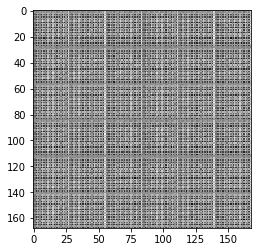

Epoch 1/2... Discriminator Loss: 2.4259... Generator Loss: 0.1767
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 4.4527
Epoch 1/2... Discriminator Loss: 2.6923... Generator Loss: 0.1964
Epoch 1/2... Discriminator Loss: 2.6794... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.8445... Generator Loss: 1.6314
Epoch 1/2... Discriminator Loss: 1.8602... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.8919... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 2.2297... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 1.7983... Generator Loss: 0.5002
Epoch 1/2... Discriminator Loss: 1.7860... Generator Loss: 0.7021


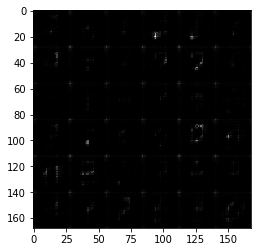

Epoch 1/2... Discriminator Loss: 1.9741... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.6235... Generator Loss: 0.9663
Epoch 1/2... Discriminator Loss: 1.9890... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.9312... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.7327... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 1.6701... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 1.8566... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.8095


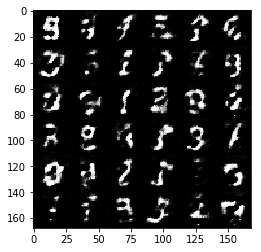

Epoch 1/2... Discriminator Loss: 1.7369... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.6373... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.6806... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.5176


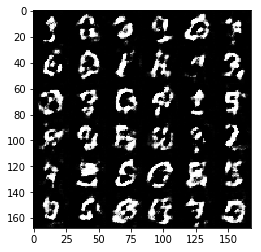

Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.6658
Epoch 1/2... Discriminator Loss: 1.6017... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.5821... Generator Loss: 1.1614
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.5360
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 0.6955


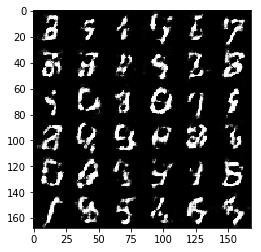

Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.5521... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 1.0500


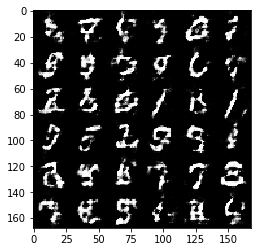

Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.9235
Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.5111... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.7010... Generator Loss: 0.7242


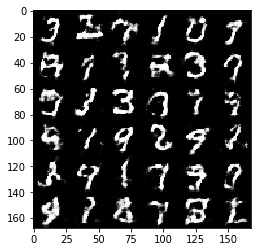

Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.4957... Generator Loss: 0.5840
Epoch 1/2... Discriminator Loss: 1.5199... Generator Loss: 0.9667
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.5761... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.9440


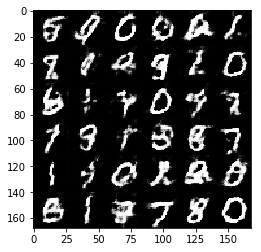

Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 1.5473... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.6161


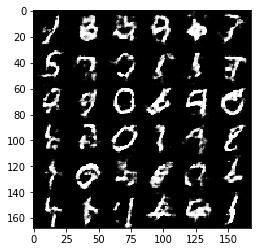

Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 1.5722... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.9225
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.6386


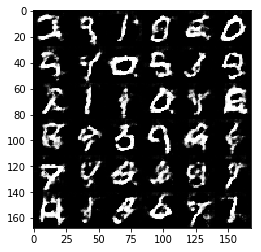

Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.4868... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 1.4944... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.5814... Generator Loss: 1.0422


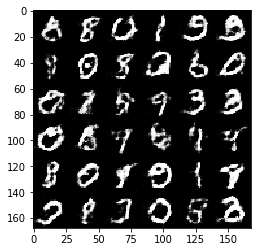

Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 1.0079
Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.4947... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 1.1678
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.7347


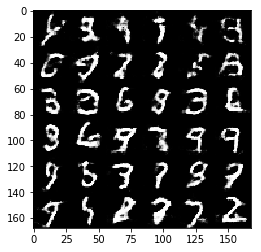

Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.5423... Generator Loss: 0.5745
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.8542


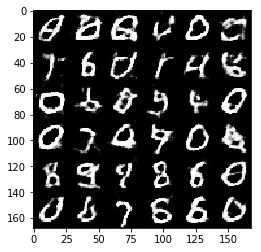

Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.5104... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.8358
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.7874
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.8833


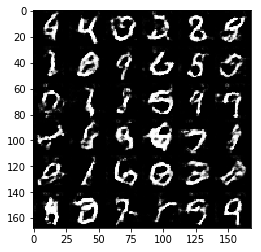

Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.8108
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.5822
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6998
Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.6559


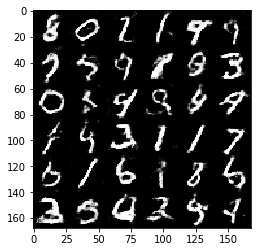

Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.5327... Generator Loss: 0.7286


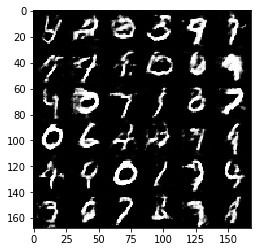

Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 1.0507
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.8446
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.4807... Generator Loss: 0.6291


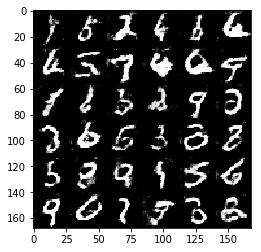

Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 1.5094... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.5213
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.5447


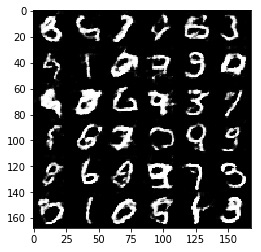

Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.5084... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.4655
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6637


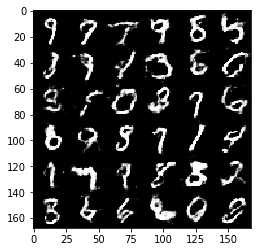

Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.5691
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.8763


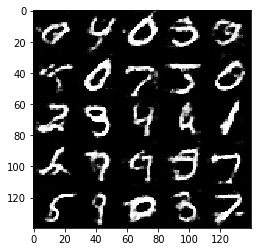

In [88]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

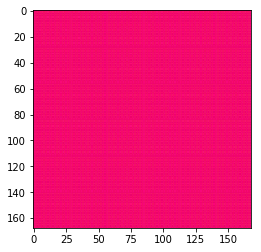

Epoch 1/1... Discriminator Loss: 3.7849... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 4.3858... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 3.2694... Generator Loss: 0.2424
Epoch 1/1... Discriminator Loss: 3.7654... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.8517... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.6859


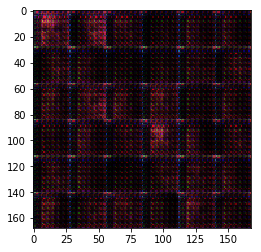

Epoch 1/1... Discriminator Loss: 2.1557... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.8535... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.8801... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 2.0651... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.9496... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.8355... Generator Loss: 0.7695


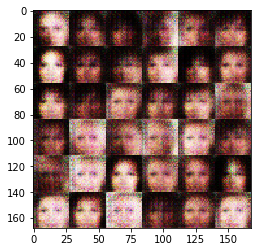

Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.6665


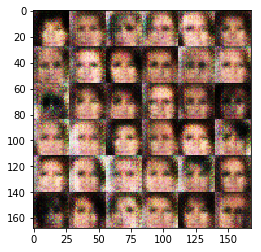

Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.8110


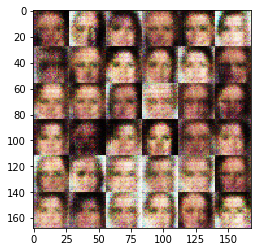

Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.7923


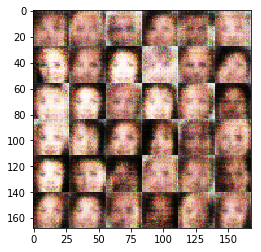

Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.7382


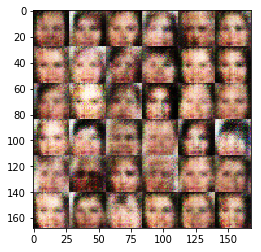

Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7835


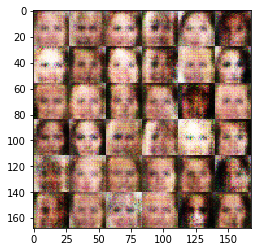

Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.8258


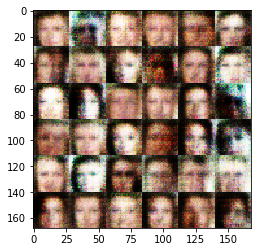

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.8055


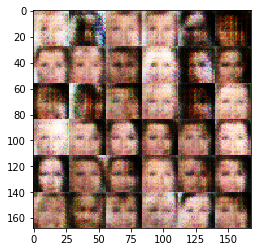

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7555


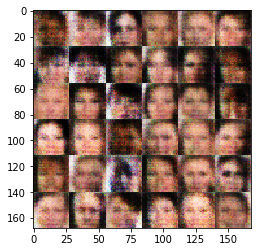

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7864


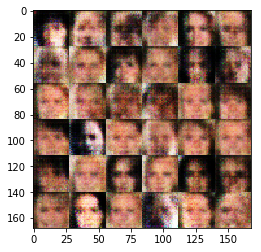

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7465


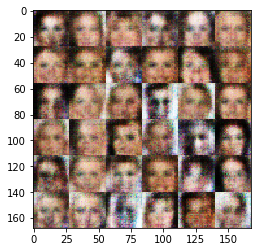

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.8481


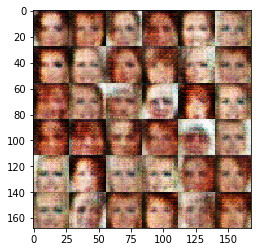

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.8998


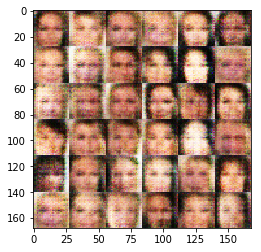

Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7594


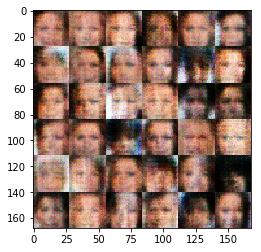

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.8439


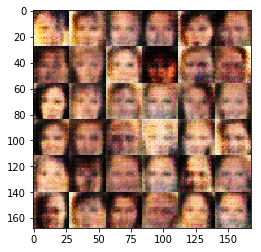

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7395


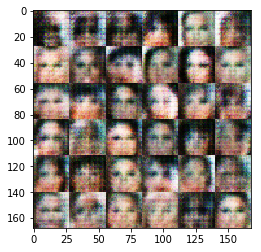

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7179


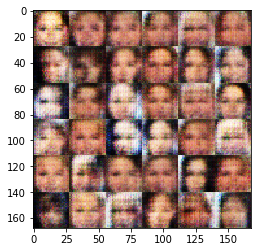

Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.8931


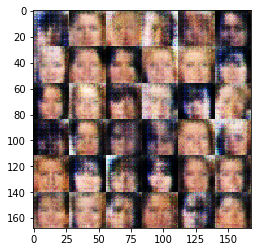

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.9197


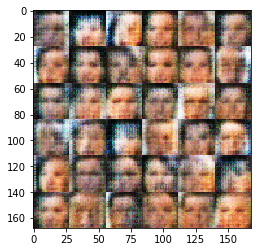

Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7952


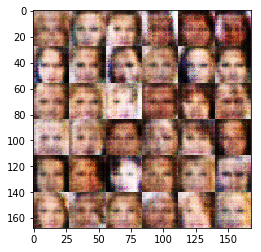

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7057


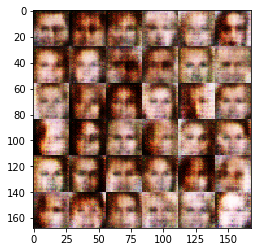

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8368


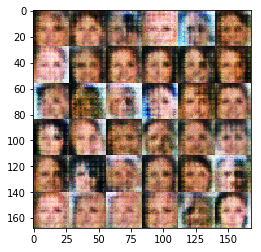

Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7474


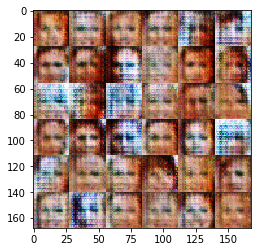

Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8121


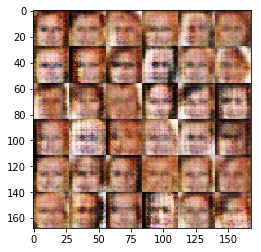

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7513


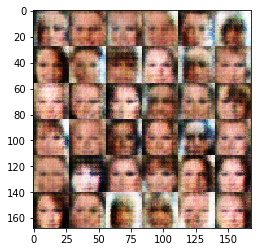

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7530


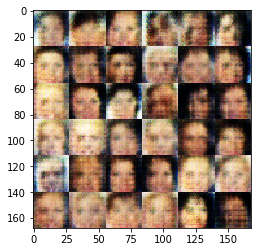

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.9225


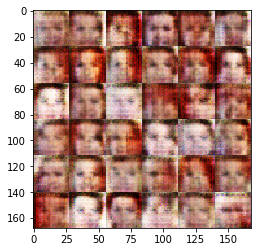

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7654


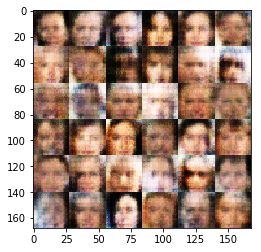

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7035


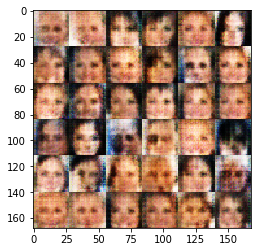

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6972


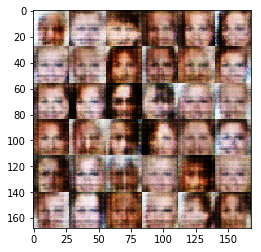

Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7935


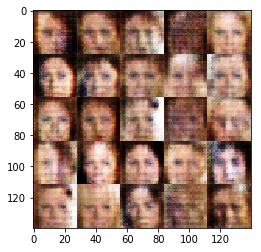

In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.